# Infinite Dilutioin Activity Coefficient Estimation

**Data Processing and Model Development**

## Step 1: Data processing

> 1. Split the data to train, cross-validation, and test.
> 2. Scale the data.
> 3. Convert to `torch.tensor`.
> 4. Make a custom dataset `torch.utils.data.Dataset`.
> 5. Make datalloaders `torch.utils.data.DataLoader`.

In [2]:
import pandas as pd

df = pd.read_csv('../data/IDAC_final.csv')
df.head(3)

,Tc_solute,Pc_solute,Vc_solute,omega_solute,dipole_solute,MW_solute,Tc_solvent,Pc_solvent,Vc_solvent,omega_solvent,dipole_solvent,MW_solvent,T_K,ln_IDAC_exp
0,550.0,4300000,0.000268,0.216,1.78,133.40422,561.6,5226120.0,0.000231,0.2680,2.940000,98.95916,328.2,0.292670
1,550.0,4300000,0.000268,0.216,1.78,133.40422,652.5,2777000.0,0.000497,0.5963,1.649998,130.22792,298.2,0.683097
2,550.0,4300000,0.000268,0.216,1.78,133.40422,652.5,2777000.0,0.000497,0.5963,1.649998,130.22792,298.2,0.636577


### 1-1. Split the data to train, cross validation and test sets

> **Test size** : 15 % \
> **Train and cross validation size** : 75 % \
> **Cross validation size** : 15 % of train-validation

In [3]:
X = df.iloc[:, :-1].to_numpy()
y = df.loc[:, 'ln_IDAC_exp'].to_numpy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

### 1-2. Scale the data with `StandardScaler`

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
#scaler = MinMaxScaler((-1, 1))

X_train = scaler.fit_transform(X_train)
X_cv = scaler.transform(X_cv)
X_test = scaler.transform(X_test)

### 1-3. Convert the data to `torch.tensor`

In [5]:
import torch

X_train = torch.tensor(X_train, ).type(torch.float32)
X_cv = torch.tensor(X_cv).type(torch.float32)
X_test = torch.tensor(X_test).type(torch.float32)

y_train = torch.tensor(y_train).type(torch.float32).unsqueeze(dim=1)
y_cv = torch.tensor(y_cv).type(torch.float32).unsqueeze(dim=1)
y_test = torch.tensor(y_test).type(torch.float32).unsqueeze(dim=1)

In [7]:
print(f'Training set: {X_train.shape}\nCross validation set: {X_cv.shape}\nTest set: {X_test.shape}')

Training set: torch.Size([4652, 13])
Cross validation set: torch.Size([822, 13])
Test set: torch.Size([967, 13])


### 1-4. Make a custom torch dataset

In [8]:
from torch.utils.data import Dataset

class IDACDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return (self.features[idx], self.labels[idx])

In [9]:
train_dataset = IDACDataset(X_train, y_train)
cv_dataset = IDACDataset(X_cv, y_cv)
test_dataset = IDACDataset(X_test, y_test)

### 1-5. Make the DataLoaders

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
cv_loader = DataLoader(cv_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Step 2: Model Architecture and Training

> 1. Make an MLP model.
> 2. Write trainer, tester, and evaluation procedures.
> 3. Train the model.
> 4. Validate it with test data.
> 5. Visulize and summerize the results
> 6. Save the model

### 2-1. Model Architecture

In [12]:
import torch
from torch import nn

class IDACModelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape, activation='relu'):
        super().__init__()

        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'relu':
            self.activation= nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            raise(ValueError(f'{activation} is not valid for this model'))

        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            self.activation,
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            self.activation,
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            self.activation,
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

# Model
INPUT_SHAPE = 13
HIDDEN_UNITS = 10
OUTPUT_SHAPE = 1
ACTIVATION = 'relu'

model = IDACModelV0(INPUT_SHAPE, HIDDEN_UNITS, OUTPUT_SHAPE, ACTIVATION)
model

IDACModelV0(
  (activation): ReLU()
  (layer_stack): Sequential(
    (0): Linear(in_features=13, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

### 2-2 Trainer, Tester, and Validation functions

In [13]:
from tqdm.auto import tqdm

#########
# Trainer
#########
def trainer(
        model : torch.nn.Module,
        data_loader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        device: torch.device = 'cpu'):

    train_loss = 0
    model.to(device)
    model.train()
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        y_preds = model(X)
        loss = loss_fn(y_preds, y)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)

    return train_loss

#########
# Tester: test the model on the cross validation data during the training process
#########
def tester(
        model: torch.nn.Module,
        data_loader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        device: torch.device = 'cpu'):

    model.to(device)
    model.eval()
    with torch.inference_mode():
        test_loss = 0
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_preds = model(X)
            test_loss += loss_fn(y_preds, y)

        test_loss /= len(data_loader)

    return test_loss

############
# Evalution : evaluate the final model on the test data
############
def evaluator(
        model: torch.nn.Module,
        data_loader: torch.utils.data.DataLoader,
        loss_fn: torch.nn.Module,
        device: torch.device = 'cpu'):

    model.eval()
    with torch.inference_mode():
        loss = 0
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_preds = model(X)
            loss += loss_fn(y_preds, y)

        loss /= len(data_loader)
    return {
        'model_name': model.__class__.__name__,
        'model_loss': loss.item(),
    }

c:\Users\sardar\anaconda3\envs\torch2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2-3. Train the model

In [14]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

torch.manual_seed(42)
torch.cuda.manual_seed(42)
# make the code device agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'this code is running on {device}')
print('-'*50)

# Hyper parameters
LEARNING_RATE = 0.01
EPOCHS = 220

INPUT_SHAPE = 13
HIDDEN_UNITS = 40
OUTPUT_SHAPE = 1
ACTIVATION = 'sigmoid'

# model_0
model_0 = IDACModelV0(INPUT_SHAPE, HIDDEN_UNITS, OUTPUT_SHAPE, ACTIVATION)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=LEARNING_RATE)


# Training Loop

for epoch in tqdm(range(EPOCHS)):
    train_loss = trainer(model_0,
            data_loader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device)

    cv_loss = tester(model_0,
           data_loader=cv_loader,
           loss_fn=loss_fn,
           device=device)

    if epoch % 20 == 0 or epoch == (EPOCHS-1):
        print(f'Epoch: {epoch: 4}| Train Loss: {train_loss: 8.4f}| Cross Validation Loss: {cv_loss: 8.4f}')

this code is running on cuda
--------------------------------------------------


  0%|          | 1/220 [00:01<04:56,  1.35s/it]

Epoch:    0| Train Loss:   1.2170| Cross Validation Loss:   0.9067


 10%|▉         | 21/220 [00:08<01:01,  3.26it/s]

Epoch:   20| Train Loss:   0.1234| Cross Validation Loss:   0.1477


 19%|█▊        | 41/220 [00:14<00:54,  3.27it/s]

Epoch:   40| Train Loss:   0.0723| Cross Validation Loss:   0.0896


 28%|██▊       | 61/220 [00:19<00:40,  3.97it/s]

Epoch:   60| Train Loss:   0.0516| Cross Validation Loss:   0.0833


 37%|███▋      | 81/220 [00:24<00:33,  4.10it/s]

Epoch:   80| Train Loss:   0.0379| Cross Validation Loss:   0.0638


 46%|████▌     | 101/220 [00:30<00:30,  3.90it/s]

Epoch:  100| Train Loss:   0.0308| Cross Validation Loss:   0.0559


 55%|█████▌    | 121/220 [00:35<00:23,  4.17it/s]

Epoch:  120| Train Loss:   0.0273| Cross Validation Loss:   0.0582


 64%|██████▍   | 141/220 [00:40<00:22,  3.53it/s]

Epoch:  140| Train Loss:   0.0226| Cross Validation Loss:   0.0559


 73%|███████▎  | 161/220 [00:45<00:14,  4.00it/s]

Epoch:  160| Train Loss:   0.0202| Cross Validation Loss:   0.0520


 82%|████████▏ | 181/220 [00:51<00:11,  3.37it/s]

Epoch:  180| Train Loss:   0.0192| Cross Validation Loss:   0.0486


 91%|█████████▏| 201/220 [00:57<00:05,  3.29it/s]

Epoch:  200| Train Loss:   0.0174| Cross Validation Loss:   0.0486


100%|██████████| 220/220 [01:03<00:00,  3.49it/s]

Epoch:  219| Train Loss:   0.0165| Cross Validation Loss:   0.0468


### 2-4. Evaluate the model

In [15]:
model_0.results = evaluator(
    model_0,
    data_loader=test_loader,
    loss_fn=loss_fn,
    device=device
)

model_0.results

100%|██████████| 31/31 [00:00<00:00, 1096.74it/s]


{'model_name': 'IDACModelV0', 'model_loss': 0.04602504521608353}

### 2-5. Visulize and summerize the results

> **Metrics:**
>> 1. **MSE:** Mean Squared Error
>> 2. **MSRE:** Root Mean Squared Error
>> 3. **MAE:** Mean Absolute Error
>> 4. **$R^{2} score$**
>> 5. **%AAD:** % Average Absolute Deviation
>> 6. **%MaxAD:** % Maximum Absolute Deviation

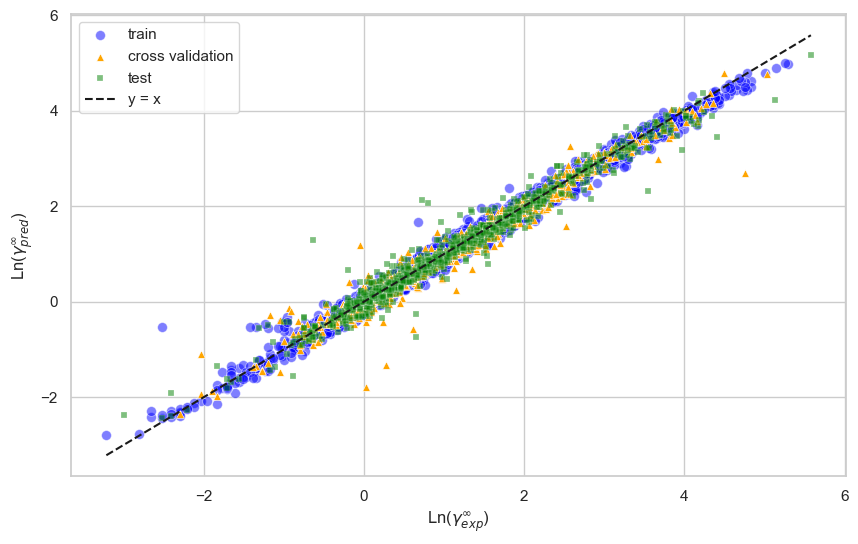

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_theme(style='whitegrid')

y_real_train = train_dataset.labels
y_real_cv = cv_dataset.labels
y_real_test = test_dataset.labels
model.eval()
with torch.inference_mode():
    y_preds_train = model_0(train_dataset.features.to(device))
    y_preds_cv = model_0(cv_dataset.features.to(device))
    y_preds_test = model_0(test_dataset.features.to(device))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot for training data
sns.scatterplot(x=y_real_train.squeeze().numpy(), y=y_preds_train.to('cpu').squeeze().numpy(),
                color='blue', marker='o', ax=ax, label='train', alpha=0.5, s=50)

# Plot for cross-validation data
sns.scatterplot(x=y_real_cv.squeeze().numpy(), y=y_preds_cv.to('cpu').squeeze().numpy(),
                color='orange', marker='^', ax=ax, label='cross validation', alpha=1, s=30)

# Plot for test data
sns.scatterplot(x=y_real_test.squeeze().numpy(), y=y_preds_test.to('cpu').squeeze().numpy(),
                color='green', marker='s', ax=ax, label='test', alpha=0.5, s=20)

# y = x
x_range = np.linspace(min(y_real_train.min(), y_real_cv.min(), y_real_test.min()),
                      max(y_real_train.max(), y_real_cv.max(), y_real_test.max()), 100)
ax.plot(x_range, x_range, 'k--', label='y = x')

# x and y labels
ax.set_xlabel(r'Ln($\gamma_{exp}^{\infty}$)')
ax.set_ylabel(r'Ln($\gamma_{pred}^{\infty}$)')

ax.legend()
plt.show()

In [17]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def calculate_deviation(y_true, y_pred):
    abs_deviation = np.abs(y_true - y_pred)
    aad = np.mean(abs_deviation)  # Average Absolute Deviation
    max_ad = np.max(abs_deviation)  # Maximum Absolute Deviation
    return aad *  100, max_ad * 100

# Calculate metrics for training data
y_train_true = y_real_train.squeeze().numpy()
y_train_pred = y_preds_train.to('cpu').squeeze().numpy()

r2_train = r2_score(y_train_true, y_train_pred)
mse_train = mean_squared_error(y_train_true, y_train_pred)
mae_train = mean_absolute_error(y_train_true, y_train_pred)
aad_train, max_ad_train = calculate_deviation(y_train_true, y_train_pred)

# Calculate metrics for cross-validation data
y_cv_true = y_real_cv.squeeze().numpy()
y_cv_pred = y_preds_cv.to('cpu').squeeze().numpy()

r2_cv = r2_score(y_cv_true, y_cv_pred)
mse_cv = mean_squared_error(y_cv_true, y_cv_pred)
mae_cv = mean_absolute_error(y_cv_true, y_cv_pred)
aad_cv, max_ad_cv = calculate_deviation(y_cv_true, y_cv_pred)

# Calculate metrics for test data
y_test_true = y_real_test.squeeze().numpy()
y_test_pred = y_preds_test.to('cpu').squeeze().numpy()

r2_test = r2_score(y_test_true, y_test_pred)
mse_test = mean_squared_error(y_test_true, y_test_pred)
mae_test = mean_absolute_error(y_test_true, y_test_pred)
aad_test, max_ad_test = calculate_deviation(y_test_true, y_test_pred)

# Calculate metrics for whole dataset
y_all_true = np.hstack([y_train_true, y_cv_true, y_test_true])
y_all_pred = np.hstack([y_train_pred, y_cv_pred, y_test_pred])

r2_all = r2_score(y_all_true, y_all_pred)
mse_all = mean_squared_error(y_all_true, y_all_pred)
mae_all = mean_absolute_error(y_all_true, y_all_pred)
aad_all, max_ad_all = calculate_deviation(y_all_true, y_all_pred)

# Create a DataFrame to store the results
metrics_df = pd.DataFrame({
    'Data Split': ['Train', 'Cross-Validation', 'Test', 'All'],
    'R² Score': [r2_train, r2_cv, r2_test, r2_all],
    'MSE': [mse_train, mse_cv, mse_test, mse_all],
    'RMSE': [np.sqrt(mse_train), np.sqrt(mse_cv), np.sqrt(mse_test), np.sqrt(mse_all)],
    'MAE': [mae_train, mae_cv, mae_test, mae_all],
    '%AAD': [aad_train, aad_cv, aad_test, aad_all],  # Average Absolute Deviation
    '%MaxAD': [max_ad_train, max_ad_cv, max_ad_test, max_ad_all]  # Maximum Absolute Deviation
})

# Display the DataFrame
metrics_df

,Data Split,R² Score,MSE,RMSE,MAE,%AAD,%MaxAD
0,Train,0.989994,0.014187,0.119110,0.085944,8.594446,198.396225
1,Cross-Validation,0.963063,0.046979,0.216746,0.131922,13.192241,207.072693
2,Test,0.967544,0.046619,0.215915,0.136275,13.627462,192.287567
3,All,0.983429,0.023241,0.152450,0.099368,9.936834,207.072693


### 2-6. Save the model
> 1. Save the `state_dict` of torch model.
> 2. Save the `scaler`.

In [20]:
from pathlib import Path
import joblib

models_dir = Path('../models')
model_name = 'IDACModel.pth'
model_path = models_dir / model_name

scaler_name = 'IDACModelScaler.pkl'
scaler_path = models_dir / scaler_name

if models_dir.is_dir():
    print(f'{models_dir} directory already exists!')
    if model_path.exists():
        print(f'{model_name} already exists!')
    else:
        print(f'saving the {model_name} in {models_dir} directory...')
        torch.save(model_0.state_dict(), model_path)

    if scaler_path.exists():
        print(f'{scaler_name} already exists!')
    else:
        print(f'saving the {scaler_name} in {models_dir} directory...')
        joblib.dump(scaler, scaler_path)
else:
    print(f'making the {models_dir} directory...')
    models_dir.mkdir()
    print(f'saving the {model_name} in {models_dir} directory...')
    torch.save(model_0.state_dict(), model_path)

    print(f'saving the {scaler_name} in {models_dir} directory...')
    joblib.dump(scaler, scaler_path)

..\models directory already exists!
IDACModel.pth already exists!
IDACModelScaler.pkl already exists!


## 3. Load And Use the model

In [19]:
def prepare_input_vector(input_vector, scaler):
    """
    Scales the input vector and converts it to a PyTorch tensor.

    Parameters:
    - input_vector: A list or NumPy array of features to be scaled.
    - scaler: The fitted scaler object used for scaling.

    Returns:
    - A PyTorch tensor ready to be fed to the model.
    """
    # Convert the input vector to a NumPy array if it isn't already
    input_array = np.array(input_vector).reshape(1, -1)

    # Scale the input vector
    scaled_vector = scaler.transform(input_array)

    # Convert the scaled vector to a PyTorch tensor
    tensor_input = torch.tensor(scaled_vector, dtype=torch.float32)

    return tensor_input

scaler = joblib.load('./models/IDACModelScaler.pkl')

input_vector = [561.6, 5226120, 0.000230947,
                0.268, 2.94, 98.95916, 652.5,
                2777000, 0.000497, 0.5963,
                1.649998201, 130.22792, 298.2]
target = 0.985816795

tensor_input = prepare_input_vector(input_vector, scaler)

# model
INPUT_SHAPE = 13
HIDDEN_UNITS = 40
OUTPUT_SHAPE = 1
ACTIVATION = 'sigmoid'

model = IDACModelV0(INPUT_SHAPE, HIDDEN_UNITS, OUTPUT_SHAPE, ACTIVATION)
model.load_state_dict(torch.load('./models/IDACModel.pth'))

model.eval()
with torch.inference_mode():
    prediction = model(tensor_input)

prediction.item(), target

C:\Users\sardar\AppData\Local\Temp\ipykernel_19228\1753928152.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/IDACModel.pth')

(0.973791241645813, 0.985816795)